## Construção do modelo de classificação:

Otimização e implantação de um modelo de regressão logística para resolver um problema de classificação binária, utilizando o SmoteTomek devido ao desbalaceamento da classe miniritária e verificar se é possível melhorar os resultados obtidos com a Logistic Regression.

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns



from imblearn.pipeline import Pipeline

from imblearn.combine import SMOTETomek

from matplotlib.ticker import PercentFormatter

from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.preprocessing import (
    FunctionTransformer,
    LabelEncoder, 
    MinMaxScaler, 
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression,  SGDClassifier

#para avaliar o permutation importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# exportar o modelo
from joblib import dump, load

from src.config import (
    ORIGINAL_DATA,  
    TREATED_DATA, 
    CLASSIFICATION_MODEL, 
    CLUSTERED_DATA
)

from src.graphics import plot_coefficients
from src.models import RANDOM_STATE
from src.models import (
    build_classification_model_pipeline,
    grid_search_cv_classifier,
    train_and_validate_classification_model,
    organize_cv_results,
)

from src.helpers import coefficient_dataframe

sns.set_theme(palette='tab10')


#### 📊 Carregamento e análise inicial dos dados

In [2]:
df = pd.read_parquet(CLUSTERED_DATA)

df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Days_Since_Enrolled,Years_Since_Enrolled,Age_Grouped,Mnt_Total,Mnt_Regular,Children,Has_Children,AcceptedCmpTotal,HasAcceptedCmp,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,663,1,46-60,1617,1529,0,0,0,0,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,113,0,46-60,27,21,2,1,0,0,0
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,312,0,46-60,776,734,0,0,0,0,1
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,139,0,18-30,53,48,1,1,0,0,0
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,161,0,31-45,422,407,1,1,0,0,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Education             2212 non-null   object  
 1   Marital_Status        2212 non-null   object  
 2   Income                2212 non-null   float64 
 3   Kidhome               2212 non-null   int64   
 4   Teenhome              2212 non-null   int64   
 5   Recency               2212 non-null   int64   
 6   MntWines              2212 non-null   int64   
 7   MntFruits             2212 non-null   int64   
 8   MntMeatProducts       2212 non-null   int64   
 9   MntFishProducts       2212 non-null   int64   
 10  MntSweetProducts      2212 non-null   int64   
 11  MntGoldProds          2212 non-null   int64   
 12  NumDealsPurchases     2212 non-null   int64   
 13  NumWebPurchases       2212 non-null   int64   
 14  NumCatalogPurchases   2212 non-null   int64   
 15  NumS

In [4]:
# Agrupamento das colunas de acordo com o pré-processamebto necessário
numerical_features = list(df.select_dtypes("number").columns)
len(numerical_features)

32

#### ⚙️ Separação da variável target e preditoras

In [5]:
X= df.drop("Response", axis=1)
y= df["Response"]

#### Fluxo da Análise:
##### 1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas: serão codificadas via OneHotEncoder

Variáveis Age e Income: estão próximas da distribuição normal. O StandardScaler é uma boa opção nesse caso.

Variáveis Days Since Enrolled e Recency: possuem distribuição uniforme. O MinMaxScaler irá colocar dentro da escala (padrão 0 e 1)

Variáveis Num e Mnt: a distribuição está enviesada, usarei o Power Transformer para deixar a distribuição mais próxima do normal

In [6]:
#colunas categóricas
one_hot_cols=[
    'Education',
    'Marital_Status',
    'Age_Grouped',
    'Kidhome',
    'Teenhome',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Years_Since_Enrolled',
    'Has_Children',
    'Children',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Cluster'
]



#colunas com a distruibuição próxima a normal
standard_cols= [
    'Income',
    'Age'
]

power_cols= X.columns[
X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

##### 🎯 Codificação da variável alvo

In [7]:
#codificação da coluna target
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

#### 📈 Configuração da validação cruzada e peso para classe minoritária

Quando trabalhamos com problemas de classificação (como este, em que o objetivo é prever a variável Response), é comum que a distribuição das classes seja desbalanceada. Se usarmos uma validação cruzada comum (como o KFold padrão), pode acontecer de alguns folds ficarem com poucas ou nenhuma instância de uma das classes.

✅ A validação cruzada estratificada garante que cada fold mantenha aproximadamente a mesma proporção de classes da variável-alvo (no caso, Response) que o conjunto original. Isso é especialmente importante quando o dataset é desbalanceado, pois evita que o modelo aprenda com dados "viciados".

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [9]:
# Preprocessamento
preprocessing = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), one_hot_cols),  #"first"
        ("PowerTransformer",PowerTransformer(), power_cols),     
        ("standard", StandardScaler(), standard_cols), 
        ("minmax",MinMaxScaler(feature_range=(-2, 2)), minmax_cols), 
    ]
)

##### 📊 Modelo sem Otimização

Primeiramente, foi construído um pipeline com:

    * Transformações nas variáveis via ColumnTransformer
    * Seleção de atributos com SelectKBest
    * Classificador: LogisticRegression com class_weight='balanced' para lidar com desbalanceamento.


In [10]:
#precisa ser usado pelo pipeline imblearn
pipeline_logreg = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif)),
        ("SMOTETomek", SMOTETomek(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(random_state=RANDOM_STATE)),  
    ]
)
pipeline_logreg.fit(X,y)
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'Age_Grouped', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'Years_Since_Enrolled',
                                                   'Has_Children', 'Children',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']...
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Mnt_Total',
                                                   'Mnt_Regular']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('minmax',
                                                  MinMaxScaler(feature_range=(-2,
                                                                              2)),
                                                  ['Recency',
                                                   'Days_Since_Enrolled'])])),
                ('feature_selection', SelectKBest()),
                ('SMOTETomek', SMOTETomek(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

In [11]:
#checar quantas colunas saíram  do preprocessamento
len(pipeline_logreg[:-3].get_feature_names_out())

47

In [12]:
pipeline_logreg[:-1].get_feature_names_out()

array(['one_hot__AcceptedCmp3_1', 'one_hot__AcceptedCmp5_1',
       'one_hot__AcceptedCmp1_1', 'one_hot__Has_Children_1',
       'one_hot__AcceptedCmpTotal_3', 'one_hot__HasAcceptedCmp_1',
       'PowerTransformer__MntMeatProducts',
       'PowerTransformer__NumCatalogPurchases',
       'PowerTransformer__Mnt_Total', 'PowerTransformer__Mnt_Regular'],
      dtype=object)

##### ✔️ Curva ROC
A curva ROC mostra a relação entre taxa de verdadeiros positivos (TPR) e falsos positivos (FPR), ideal para verificar desempenho em diferentes thresholds.

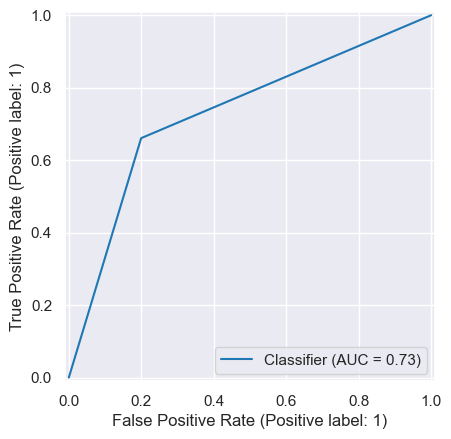

In [13]:
#ROC
#explique a cruva roc'
y_pred = cross_val_predict(pipeline_logreg, X, y, cv=kf, n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y, y_pred)


##### ✔️ Curva Precision-Recall
É especialmente útil em casos de classes desbalanceadas, pois mostra como a precisão varia com o recall (foca no desempenho da classe positiva). A área sob essa curva (AUPRC) mede a capacidade do modelo de identificar corretamente os positivos com alta confiança.


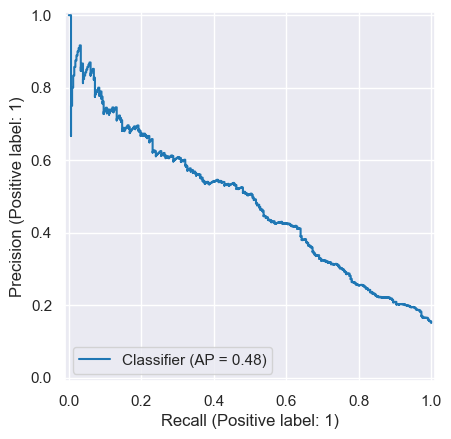

In [14]:
y_pred = cross_val_predict(pipeline_logreg, X, y, cv=kf, n_jobs=-1, method='decision_function')
precision_recall = PrecisionRecallDisplay.from_predictions(y, y_pred)

In [15]:
#otimizar hiperparâmetros
pipeline_logreg.named_steps

{'preprocessing': ColumnTransformer(transformers=[('one_hot', OneHotEncoder(drop='first'),
                                  ['Education', 'Marital_Status', 'Age_Grouped',
                                   'Kidhome', 'Teenhome', 'AcceptedCmp3',
                                   'AcceptedCmp4', 'AcceptedCmp5',
                                   'AcceptedCmp1', 'AcceptedCmp2', 'Complain',
                                   'Years_Since_Enrolled', 'Has_Children',
                                   'Children', 'AcceptedCmpTotal',
                                   'HasAcceptedCmp', 'Cluster']),
                                 ('PowerTransformer', PowerTransf...
                                  ['MntWines', 'MntFruits', 'MntMeatProducts',
                                   'MntFishProducts', 'MntSweetProducts',
                                   'MntGoldProds', 'NumDealsPurchases',
                                   'NumWebPurchases', 'NumCatalogPurchases',
                             

##### 🔧 Otimização com GridSearchCV
Utilização do GridSearchCV para buscar a melhor combinação de parâmetros com múltiplas métricas, escolhendo como métrica principal a average precision.

In [16]:
param_grid= {
    'feature_selection': [SelectKBest(score_func=f_classif, k=k) for k in [15, 22]] + [FunctionTransformer(validate=False)],
    'model__C':np.logspace(-3,3,7),
    'model__solver': ['libnear', 'saga', 'lbfgs'],
    'model__penalty':['l1', 'l2', 'elasticnet', 'none'],
}
    

##### Parâmetros
* feature_selection:
    * teste com dois valores de k (15 e 22) para avaliar se a seleção de um subconjunto melhora a performance. Como o dataset é pequeno, também foi testada FunctionTransformer para simular nenhuma seleção (usando todos os atributos).
* model__C (parâmetro de regularização da regressão logística):
    * Valores em escala logarítmica (10^-3 a 10^3) foram testados para capturar sub e sobreajuste.
* model__penalty:
    * Diversos tipos de penalização foram testados: L1 (Lasso), L2 (Ridge), ElasticNet (combinação das duas) e none (sem penalização) para encontrar o melhor viés-bias/variância.
* model__solver:
    * Cada tipo de penalidade exige solvers compatíveis. Mesmo sabendo que algumas combinações irão gerar warnings (e falhar), optamos por deixá-las no grid para explorar ao máximo o espaço de busca.


** warnings.filterwarnings('ignore'): opção por silenciar os avisos de que muitas combinações são incompatíveis entre solver e penalty, mas o GridSearch ignora essas combinações automaticamente.

In [17]:
grid_search = GridSearchCV(
    pipeline_logreg,
    param_grid,
    scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'],
    n_jobs=-1,
    refit = 'average_precision'
)
grid_search

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Age_Grouped',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'Has_Children',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'Has...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection': [SelectKBest(k=15),
                                               SelectKBest(k=22),
                                               FunctionTransformer()],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['libnear', 'saga', 'lbfgs']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'])

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
grid_search.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'Age_Grouped',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'Complain',
                                                                          'Years_Since_Enrolled',
                                                                          'Has_Children',
                                                                          'Children',
                                                                          'AcceptedCmpTotal',
                                                                          'Has...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection': [SelectKBest(k=15),
                                               SelectKBest(k=22),
                                               FunctionTransformer()],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['libnear', 'saga', 'lbfgs']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy', 'f1'])

In [20]:
grid_search.best_params_

{'feature_selection': FunctionTransformer(),
 'model__C': 1.0,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

##### 📌 Melhores parâmetros encontrados:

1. feature_selection: FunctionTransformer()
Esse passo indica que nenhuma transformação adicional foi aplicada nas features.

FunctionTransformer() é basicamente um "transformador neutro", ou seja, os dados foram mantidos como estão.


2. model__C: 1.0
C é o parâmetro de regularização da Regressão Logística.

Ele controla o quanto o modelo penaliza coeficientes grandes para evitar overfitting.

C é inversamente proporcional à regularização → quanto menor o C, maior a regularização.

📌 Interpretação de C = 1.0:

Um valor de 1.0 significa que o modelo aplica uma regularização moderada.

Nem muito forte (como C = 0.01), nem fraca (como C = 100).

3. model__penalty: 'l1'
Define o tipo de penalização (regularização) usada.

'l1' refere-se à Lasso (Least Absolute Shrinkage and Selection Operator).

📌 Efeitos da penalização L1:

Faz com que alguns coeficientes se tornem exatamente zero, ou seja, funciona como um tipo de seleção de variáveis automática.

Ideal quando você suspeita que nem todas as variáveis são úteis para o modelo.

4. model__solver: 'saga'
Define o algoritmo de otimização usado para encontrar os melhores coeficientes da regressão.

'saga' é um dos poucos solvers que suporta penalização l1 com dados grandes e esparsos.

📌 Por que usar saga?

Suporta L1 e ElasticNet.

Funciona bem com grandes conjuntos de dados.

É eficiente com dados que passaram por técnicas como SMOTE, que geram amostras sintéticas.

In [21]:
grid_search.best_score_

0.6694470689371759

In [22]:
df_results_gs = pd.DataFrame(
    {
        "auprc": grid_search.cv_results_['mean_test_average_precision'],
        "auroc": grid_search.cv_results_['mean_test_roc_auc'],
        "accuracy": grid_search.cv_results_['mean_test_accuracy'],
        "f1": grid_search.cv_results_['mean_test_f1'],
    }
)
df_results_gs        
        

,auprc,auroc,accuracy,f1
0,NaN,NaN,NaN,NaN
1,0.150542,0.500000,0.430180,0.157067
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,0.420322,0.778938,0.695754,0.407804
...,...,...,...,...
247,NaN,NaN,NaN,NaN
248,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN


<Axes: >

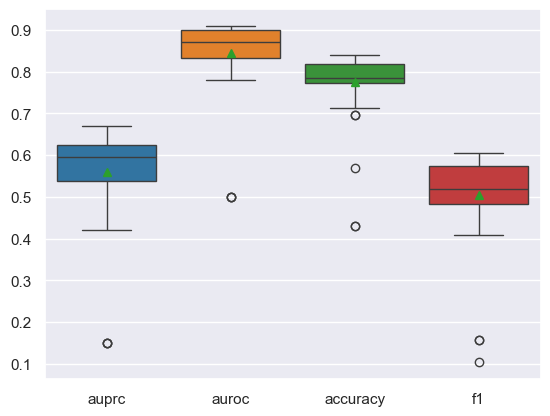

In [23]:
sns.boxplot(
    data=df_results_gs,
    showmeans=True,
)

In [24]:
grid_search.best_params_

{'feature_selection': FunctionTransformer(),
 'model__C': 1.0,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

##### 📌 Melhores parâmetros encontrados:
* Sem seleção de variáveis (FunctionTransformer()): usar todas as variáveis se mostrou melhor para o desempenho geral.

* C=10.0: regularização mais leve, permitindo maior flexibilidade ao modelo.

* penalty='l2' com solver='saga': combinação estável, eficiente e compatível para L2, especialmente em datasets maiores e esparsos.

##### ✅ Pipeline Final com os Melhores Parâmetros

In [25]:
#criar o pipeline usando os melhores parâmetros - automatizando 
pipeline_logreg_best = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("SMOTETomek", SMOTETomek(random_state=RANDOM_STATE)),
        ("model", LogisticRegression(
            random_state=RANDOM_STATE,
            C= grid_search.best_params_['model__C'],
            penalty=grid_search.best_params_['model__penalty'], 
            solver= grid_search.best_params_['model__solver']  
        )),  
    ]
)


In [26]:
##### 📊 Avaliação Final com Cross-Validation

In [27]:
scores= cross_validate(
    pipeline_logreg_best,
    X,
    y,
    cv=kf,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision'],
    n_jobs=-1
)
    
    

In [28]:
scores

{'fit_time': array([1.29810309, 1.39781356, 1.36858249, 1.34812617, 1.39381433]),
 'score_time': array([0.13041115, 0.09592557, 0.10270858, 0.10957837, 0.09402823]),
 'test_accuracy': array([0.83747178, 0.83972912, 0.81447964, 0.85972851, 0.86199095]),
 'test_precision': array([0.47747748, 0.48214286, 0.43697479, 0.51785714, 0.52475248]),
 'test_recall': array([0.79104478, 0.80597015, 0.7761194 , 0.87878788, 0.8030303 ]),
 'test_roc_auc': array([0.90512861, 0.87910845, 0.8878607 , 0.92105899, 0.92089781]),
 'test_average_precision': array([0.65806472, 0.63389095, 0.669173  , 0.66991519, 0.67853605])}

In [29]:
scores['time']=scores['fit_time'] + scores['score_time']

In [30]:
df_scores_best = pd.DataFrame(scores)
df_scores_best 

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,1.298103,0.130411,0.837472,0.477477,0.791045,0.905129,0.658065,1.428514
1,1.397814,0.095926,0.839729,0.482143,0.805970,0.879108,0.633891,1.493739
2,1.368582,0.102709,0.814480,0.436975,0.776119,0.887861,0.669173,1.471291
3,1.348126,0.109578,0.859729,0.517857,0.878788,0.921059,0.669915,1.457705
4,1.393814,0.094028,0.861991,0.524752,0.803030,0.920898,0.678536,1.487843


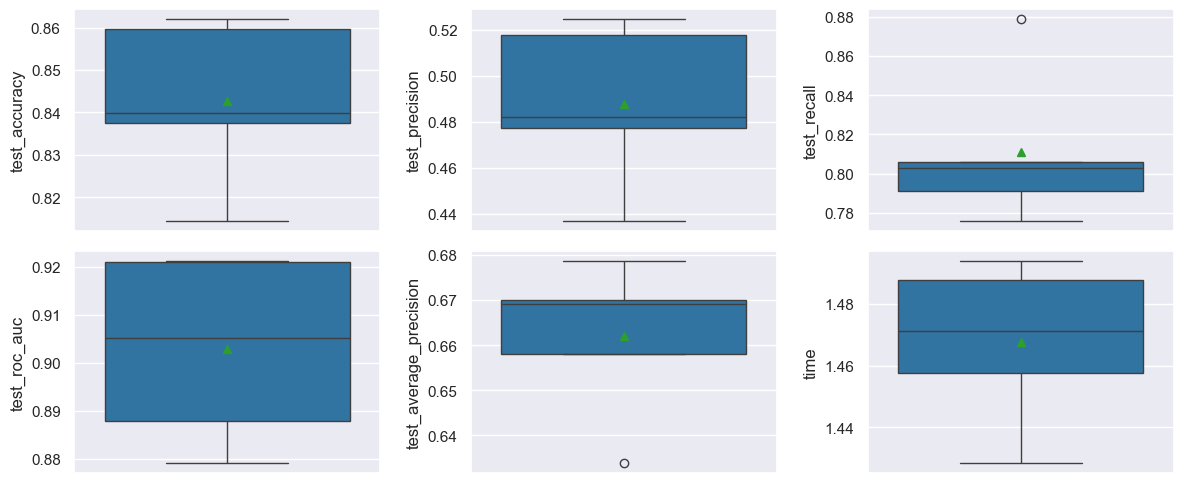

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,5), tight_layout=True)

cols = df_scores_best.columns[2:].tolist()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(y=col, data=df_scores_best, ax=ax, showmeans=True)

plt.show()


In [32]:
#analisar as features mais importantes para o) modelo)
pipeline_logreg_best.fit(X,y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Education',
                                                   'Marital_Status',
                                                   'Age_Grouped', 'Kidhome',
                                                   'Teenhome', 'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2', 'Complain',
                                                   'Years_Since_Enrolled',
                                                   'Has_Children', 'Children',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Cluster']...
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'Mnt_Total',
                                                   'Mnt_Regular']),
                                                 ('standard', StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('minmax',
                                                  MinMaxScaler(feature_range=(-2,
                                                                              2)),
                                                  ['Recency',
                                                   'Days_Since_Enrolled'])])),
                ('SMOTETomek', SMOTETomek(random_state=42)),
                ('model',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='saga'))])

In [33]:
coefs = coefficient_dataframe(
    pipeline_logreg_best['model'].coef_[0],
    pipeline_logreg_best[:-1].get_feature_names_out() #o nome das features
)
coefs

,coefficient
PowerTransformer__Mnt_Regular,-1.941275
one_hot__Education_Basic,-1.309486
one_hot__Has_Children_1,-1.115771
minmax__Recency,-1.009675
PowerTransformer__NumStorePurchases,-0.921284
one_hot__Teenhome_1,-0.899014
PowerTransformer__MntWines,-0.864551
one_hot__Children_3,-0.836518
one_hot__Teenhome_2,-0.742657
one_hot__Complain_1,-0.541353


##### 🔍 Análise dos Coeficientes
Ao analisar os coeficientes, percebe-se que as variáveis com valores contínuos possuem uma interpretação ligeiramente diferente das variáveis categóricas. No entanto, em ambos os casos, coeficientes mais negativos indicam maior impacto na probabilidade da classe 0 (falta de engajamento), enquanto coeficientes mais positivos indicam maior impacto na probabilidade da classe 1 (engajamento) da variável target.

Destacam-se entre os coeficientes negativos:

    * Formação básica (nível educacional mais baixo),

    * Gastos com produtos regulares (quanto menor o gasto, menor o engajamento),

    * Presença de filhos (adolescentes ou crianças),

    * Maior tempo desde a última compra.

Entre os coeficientes positivos, destacam-se:

    * Pessoas com doutorado,

    * Aqueles que aceitaram campanhas promocionais 1 e 2,

    * Solteiros, que apresentaram maior propensão ao engajamento.

A análise dos coeficientes corrobora os padrões observados na análise exploratória e nos agrupamentos por cluster, o que reforça a consistência do modelo com os dados.


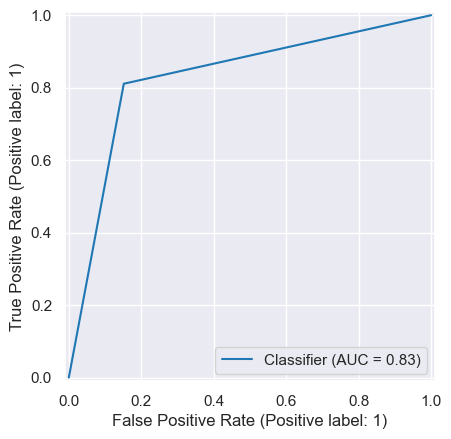

In [34]:
#ROC
#explique a cruva roc'
y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=kf, n_jobs=-1)
roc = RocCurveDisplay.from_predictions(y, y_pred)


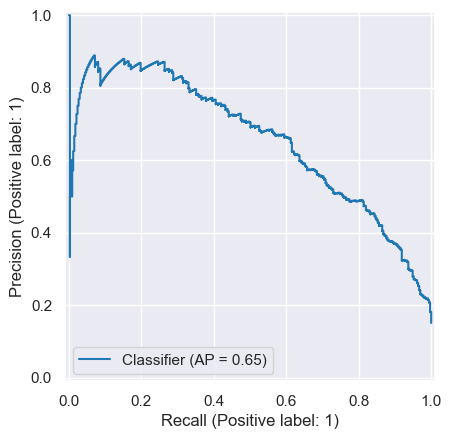

In [35]:
y_pred = cross_val_predict(pipeline_logreg_best, X, y, cv=kf, n_jobs=-1, method='decision_function')
precision_recall = PrecisionRecallDisplay.from_predictions(y, y_pred)

<function matplotlib.pyplot.show(close=None, block=None)>

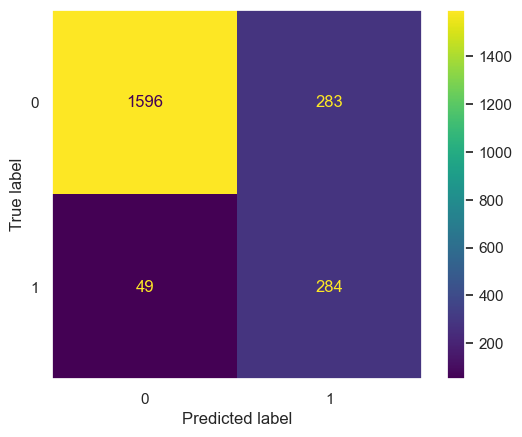

In [36]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,

)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

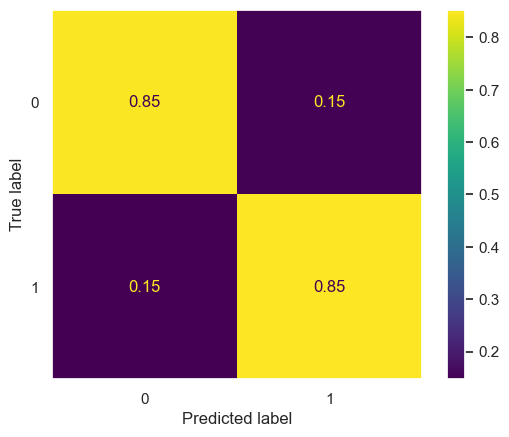

In [37]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize='true',

)
plt.grid(False)
plt.show

#### Conclusão

✅ Conclusão
A aplicação do SmoteTomek toma mais tempo e trouxe resultados muito similares a aplicação do Logist Regression sem a aplicação do  SmoteTomek.

Rebalanceamento sem considerar o modelo
Técnicas de reamostragem não levam em conta como o classificador vai reagir ao novo conjunto de dados. E como a Regressão Logística é um modelo linear, ele pode se beneficiar mais de ajustes diretos no peso das classes.


Abaixo, a tabela compara as métricas antes e depois da otimização:


| Métrica                  | Antes da Otimização | Após Otimização |
|--------------------------|---------------------|------------------|
| Área sob a curva ROC     | 73%                 | 83%              |
| Área sob a curva PRC     | 49%                 | 65%              |

